In [24]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import time
import pickle as pk
from edo_fdm_model import fdm
import matplotlib.pyplot as plt


In [25]:
k = 0.01
t_lower = 0.0
t_upper = 10
phi = 0.2
ksi = 0.0
cb = 0.15
C_nmax = 0.55
mi_n = 0.2
lambd_nb = 1.8
lambd_bn = 0.1
y_n = 0.1
initial = 0.1

size_t = int(((t_upper - t_lower) / (k)))

initial_var = 0.1

initial_list = np.linspace(
    initial * (1 - initial_var), initial * (1 + initial_var), num=size_t + 1, endpoint=True
)

print(
    "Steps in time = {:d}\n".format(
        size_t,
    )
)

t_np = np.linspace(t_lower, t_upper, num=size_t + 1, endpoint=True)

for i, initial in enumerate(initial_list):
    if i == 0:
        Cp_old, Cl_old = fdm(
            k,
            phi,
            ksi,
            cb,
            C_nmax,
            lambd_nb,
            mi_n,
            lambd_bn,
            y_n,
            t_lower,
            t_upper,
            initial,
            plot=False,
        )

    else:
        Cp_new, Cl_new = fdm(
            k,
            phi,
            ksi,
            cb,
            C_nmax,
            lambd_nb,
            mi_n,
            lambd_bn,
            y_n,
            t_lower,
            t_upper,
            initial,
            plot=False,
        )

        Cp_old = np.vstack((Cp_old.copy(), Cp_new))
        Cl_old = np.vstack((Cl_old.copy(), Cl_new))

    print(i + 1, "de", len(initial_list))

Steps in time = 10

1 de 11
2 de 11
3 de 11
4 de 11
5 de 11
6 de 11
7 de 11
8 de 11
9 de 11
10 de 11
11 de 11


In [26]:
tt, ii = np.meshgrid(t_np, initial_list)

data_input_np = np.array([Cl_old.flatten(), Cp_old.flatten()]).T

if torch.cuda.is_available():
    device = torch.device("cuda")
    t = (
        torch.tensor(tt, dtype=torch.float32, requires_grad=True)
        .reshape(-1, 1)
        .to(device)
    )
    initial = (
        torch.tensor(ii, dtype=torch.float32, requires_grad=True)
        .reshape(-1, 1)
        .to(device)
    )
    data_input = torch.tensor(data_input_np, dtype=torch.float32).to(device)

else:
    device = torch.device("cpu")
    t = torch.tensor(tt, dtype=torch.float32, requires_grad=True).reshape(-1, 1)
    initial = torch.tensor(ii, dtype=torch.float32, requires_grad=True).reshape(-1, 1)
    data_input = torch.tensor(data_input_np, dtype=torch.float32)

print(device)

cpu


In [27]:
activation_dict = {
    "Elu": nn.ELU,
    "LeakyReLU": nn.LeakyReLU,
    "Sigmoid": nn.Sigmoid,
    "Softplus": nn.Softplus,
    "Tanh": nn.Tanh,
    "Linear": nn.Linear,
    "ReLU": nn.ReLU,
    "RReLU": nn.RReLU,
    "SELU": nn.SELU,
    "CELU": nn.CELU,
    "GELU": nn.GELU,
    "SiLU": nn.SiLU,
    "GLU": nn.GLU,
}

In [28]:
arch_str = "Tanh--32__Tanh--32__Tanh--32__GELU--32"

In [29]:
def generate_model(arch_str):
    hidden_layers = arch_str.split("__")

    modules = []

    for params in hidden_layers:
        if len(params) != 0:
            activation, out_neurons = params.split("--")

            if len(modules) == 0:
                if activation == "Linear":
                    modules.append(activation_dict[activation](2, int(out_neurons)))

                else:
                    modules.append(nn.Linear(2, int(out_neurons)))
                    modules.append(activation_dict[activation]())

            else:
                if activation == "Linear":
                    modules.append(
                        activation_dict[activation](int(in_neurons), int(out_neurons))
                    )

                else:
                    modules.append(nn.Linear(int(in_neurons), int(out_neurons)))
                    modules.append(activation_dict[activation]())

            in_neurons = out_neurons

    modules.append(nn.Linear(int(in_neurons), 2))

    return nn.Sequential(*modules)

In [30]:
model = generate_model(arch_str).to(device)

print(model)

Sequential(
  (0): Linear(in_features=2, out_features=32, bias=True)
  (1): Tanh()
  (2): Linear(in_features=32, out_features=32, bias=True)
  (3): Tanh()
  (4): Linear(in_features=32, out_features=32, bias=True)
  (5): Tanh()
  (6): Linear(in_features=32, out_features=32, bias=True)
  (7): GELU(approximate=none)
  (8): Linear(in_features=32, out_features=2, bias=True)
)


In [31]:
def initial_condition(t):
    Cl = torch.zeros_like(t)
    Cp = torch.zeros_like(t) + 0.2
    return torch.cat([Cl, Cp], dim=1)

In [32]:
def pde(t, lambd_nb, model):
    mesh = torch.cat([t, lambd_nb], dim=1)

    Cl, Cp = model(mesh).split(1, dim=1)

    # Calculando Cp

    dCp_dt = torch.autograd.grad(
        Cp,
        t,
        grad_outputs=torch.ones_like(Cp),
        create_graph=True,
        retain_graph=True,
    )[0]

    Cp_eq = (cb - lambd_nb * Cl) * Cp * phi - dCp_dt

    # Calculando Cl

    dCl_dt = torch.autograd.grad(
        Cl,
        t,
        grad_outputs=torch.ones_like(Cl),
        create_graph=True,
        retain_graph=True,
    )[0]

    Cl_eq = (y_n * Cp * (C_nmax - 1) - (lambd_bn * Cp + mi_n)) * Cl * phi - dCl_dt

    del dCl_dt
    del dCp_dt

    torch.cuda.empty_cache()

    return torch.cat([Cl_eq, Cp_eq], dim=1)

In [33]:
def train(n_epochs, batch_size, decay_rate, model, initial, device, data_input, t):
    loss_fn = nn.MSELoss()  # binary cross entropy
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    lbfgs = torch.optim.LBFGS(
            model.parameters(),
            lr=1.0,
            max_iter=50000,
            max_eval=50000,
            history_size=50,
            tolerance_grad=1e-7,
            tolerance_change=1.0 * np.finfo(float).eps,
            line_search_fn="strong_wolfe",
        )

    lr_scheduler = optim.lr_scheduler.ExponentialLR(
        optimizer=optimizer, gamma=decay_rate
    )
    loss_fn = nn.MSELoss()  # binary cross entropy
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    decay_rate = 0.99

    lr_scheduler = optim.lr_scheduler.ExponentialLR(
        optimizer=optimizer, gamma=decay_rate
    )
    C_pde_loss_it = torch.zeros(n_epochs).to(device)
    C_data_loss_it = torch.zeros(n_epochs).to(device)
    C_initial_loss_it = torch.zeros(n_epochs).to(device)
    C_initial = initial_condition(t).to(device)

    for epoch in range(n_epochs):
        for i in range(0, len(t), batch_size):
            t_initial = torch.zeros_like(t[i : i + batch_size])

            mesh = torch.cat([t_initial, initial[i : i + batch_size]], dim=1)
            C_initial_pred = model(mesh)

            loss_initial = loss_fn(C_initial[i : i + batch_size], C_initial_pred)

            mesh = torch.cat(
                [t[i : i + batch_size], initial[i : i + batch_size]], dim=1
            )
            C_pred = model(mesh)

            loss_pde = loss_fn(
                pde(t[i : i + batch_size], initial[i : i + batch_size], model),
                torch.cat([t_initial, t_initial], dim=1),
            )

            loss_data = loss_fn(C_pred, data_input[i : i + batch_size])

            loss = 10 * loss_initial + loss_pde + 10 * loss_data

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            lr_scheduler.step()

        C_pde_loss_it[epoch] = loss_pde.item()
        C_initial_loss_it[epoch] = loss_initial.item()
        C_data_loss_it[epoch] = loss_data.item()

        loss_lb = lambda : loss

        lbfgs.step(loss_lb)

        if epoch % 100 == 0:
            print(f"Finished epoch {epoch}, latest loss {loss}")

    return model, C_pde_loss_it, C_initial_loss_it, C_data_loss_it


decay_rate = 0.99
n_epochs = 500
batch_size = 100000

model, C_pde_loss_it, C_initial_loss_it, C_data_loss_it = train(
    n_epochs=n_epochs,
    batch_size=batch_size,
    decay_rate=decay_rate,
    model=model,
    initial=initial,
    device=device,
    data_input=data_input,
    t=t,
)

Finished epoch 0, latest loss 1.451501488685608


Finished epoch 100, latest loss 0.014030392281711102
Finished epoch 200, latest loss 0.012352123856544495
Finished epoch 300, latest loss 0.011817625723779202
Finished epoch 400, latest loss 0.011624765582382679


In [34]:
pinn_file = "epochs_{}__batch_{}__arch_".format(n_epochs, batch_size) + arch_str

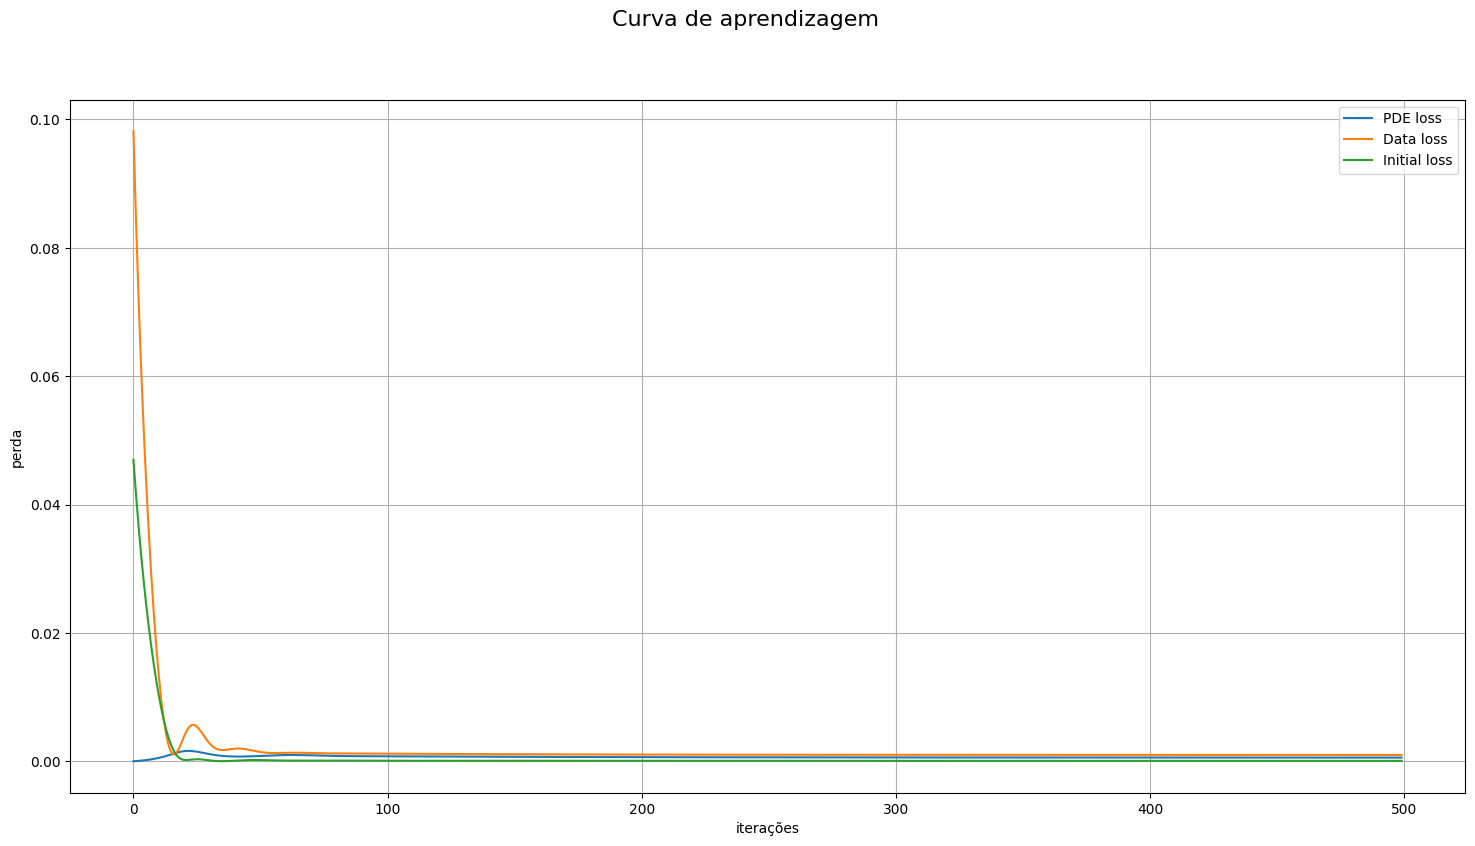

In [35]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=[18, 9])

fig.suptitle("Curva de aprendizagem", fontsize=16)

# Plotango 3D
ax = fig.add_subplot(1, 1, 1)

ax.set_xlabel("iterações")
ax.set_ylabel("perda")
ax.plot(
    range(len(C_pde_loss_it.cpu().numpy())),
    C_pde_loss_it.cpu().numpy(),
    label="PDE loss",
)
ax.plot(
    range(len(C_data_loss_it.cpu().numpy())),
    C_data_loss_it.cpu().numpy(),
    label="Data loss",
)
ax.plot(
    range(len(C_initial_loss_it.cpu().numpy())),
    C_initial_loss_it.cpu().numpy(),
    label="Initial loss",
)
# ax.set_yscale("log")
ax.grid()
ax.legend()

plt.show()

In [36]:
model_cpu = model.to("cpu")

speed_up = []

mesh = torch.cat([t, initial], dim=1).to("cpu")

for i in range(10):
    fdm_start = time.time()

    for ini in initial_list:

        _, _ = fdm(
            k,
            phi,
            ksi,
            cb,
            C_nmax,
            lambd_nb,
            mi_n,
            lambd_bn,
            y_n,
            t_lower,
            t_upper,
            ini,
        )

    fdm_end = time.time()

    pinn_start = time.time()

    with torch.no_grad():
        Cl_pinn, Cp_pinn = model_cpu(mesh).split(1, dim=1)

    pinn_end = time.time()

    fdm_time = fdm_end - fdm_start

    pinn_time = pinn_end - pinn_start

    speed_up.append(fdm_time / pinn_time)

In [37]:
mean_speed_up = np.mean(speed_up)
std_speed_up = np.std(speed_up)

rmse = np.mean(
    [
        ((Cl_p[0] - Cl_f) ** 2 + (Cp_p[0] - Cp_f) ** 2) ** 0.5
        for Cl_p, Cp_p, Cl_f, Cp_f in zip(
            Cl_pinn, Cp_pinn, Cl_old.flatten(), Cp_old.flatten()
        )
    ]
)

max_ae = np.max(
    [
        [((Cl_p[0] - Cl_f) ** 2) ** 0.5, ((Cp_p[0] - Cp_f) ** 2) ** 0.5]
        for Cl_p, Cp_p, Cl_f, Cp_f in zip(
            Cl_pinn, Cp_pinn, Cl_old.flatten(), Cp_old.flatten()
        )
    ]
)

In [38]:
output = {
    "rmse": rmse,
    "max_ae": max_ae,
    "mean_speed_up": mean_speed_up,
    "std_speed_up": std_speed_up,
    "Cl_pinn": Cl_pinn,
    "Cp_pinn": Cp_pinn,
}

In [39]:
print("Erro absoluto médio", rmse)
print("Erro absoluto máximo", max_ae)
print("Speed Up: {} +/-{}".format(mean_speed_up, std_speed_up))

Erro absoluto médio 0.034998916
Erro absoluto máximo 0.09816724
Speed Up: 0.5903550593664688 +/-0.2803723547581455


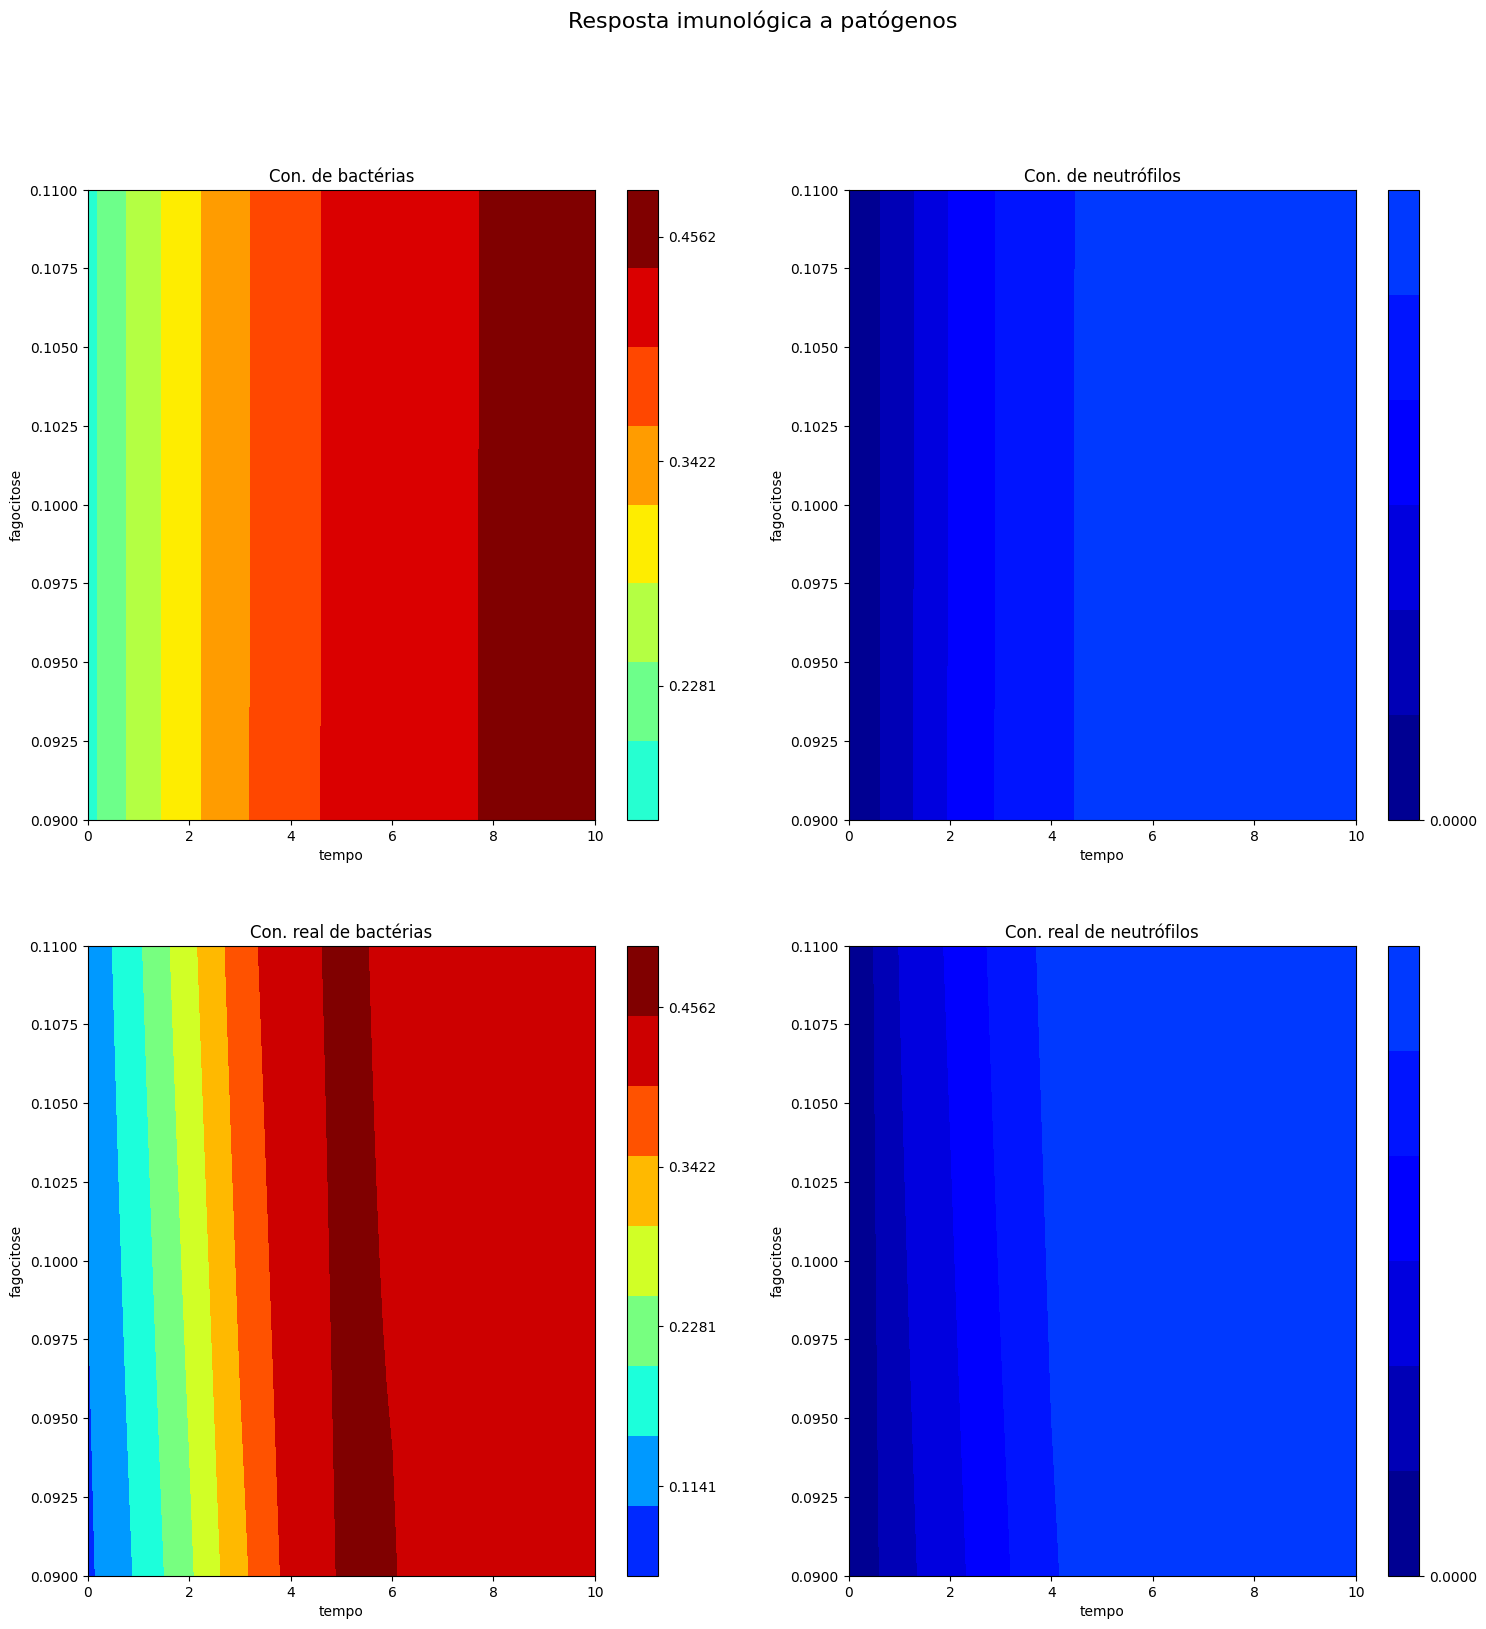

In [40]:
Cl_pinn_np = Cl_pinn.detach().numpy().reshape(size_t + 1, size_t + 1)
Cp_pinn_np = Cp_pinn.detach().numpy().reshape(size_t + 1, size_t + 1)

fig = plt.figure(figsize=[18, 18])

fig.suptitle("Resposta imunológica a patógenos", fontsize=16)

vmin = 0
vmax = np.max(
    [
        np.max(Cp_pinn.cpu().numpy()),
        np.max(Cl_pinn.cpu().numpy()),
        np.max(Cp_old),
        np.max(Cl_old),
    ]
)

# Plotango 3D
ax = fig.add_subplot(2, 2, 1)

contour = ax.contourf(
    tt,
    ii,
    Cp_pinn_np,
    cmap="jet",
    vmin=vmin,
    vmax=vmax,
)
ax.set_title("Con. de bactérias")
ax.set_xlabel("tempo")
ax.set_ylabel("fagocitose")
colobar = fig.colorbar(contour, ticks=np.linspace(vmin, vmax, num=5))

# Plotando 2D

ax = fig.add_subplot(2, 2, 2)

contour = ax.contourf(
    tt,
    ii,
    Cl_pinn_np,
    cmap="jet",
    vmin=vmin,
    vmax=vmax,
)
ax.set_title("Con. de neutrófilos")
ax.set_xlabel("tempo")
ax.set_ylabel("fagocitose")

colobar = fig.colorbar(contour, ticks=np.linspace(vmin, vmax, num=5))

# Plotango 3D
ax = fig.add_subplot(2, 2, 3)

contour = ax.contourf(
    tt,
    ii,
    Cp_old.reshape(size_t + 1, size_t + 1),
    cmap="jet",
    vmin=vmin,
    vmax=vmax,
)
ax.set_title("Con. real de bactérias")
ax.set_xlabel("tempo")
ax.set_ylabel("fagocitose")
colobar = fig.colorbar(contour, ticks=np.linspace(vmin, vmax, num=5))

# Plotando 2D

ax = fig.add_subplot(2, 2, 4)

contour = ax.contourf(
    tt,
    ii,
    Cl_old.reshape(size_t + 1, size_t + 1),
    cmap="jet",
    vmin=vmin,
    vmax=vmax,
)
ax.set_title("Con. real de neutrófilos")
ax.set_xlabel("tempo")
ax.set_ylabel("fagocitose")

colobar = fig.colorbar(contour, ticks=np.linspace(vmin, vmax, num=5))

plt.show()

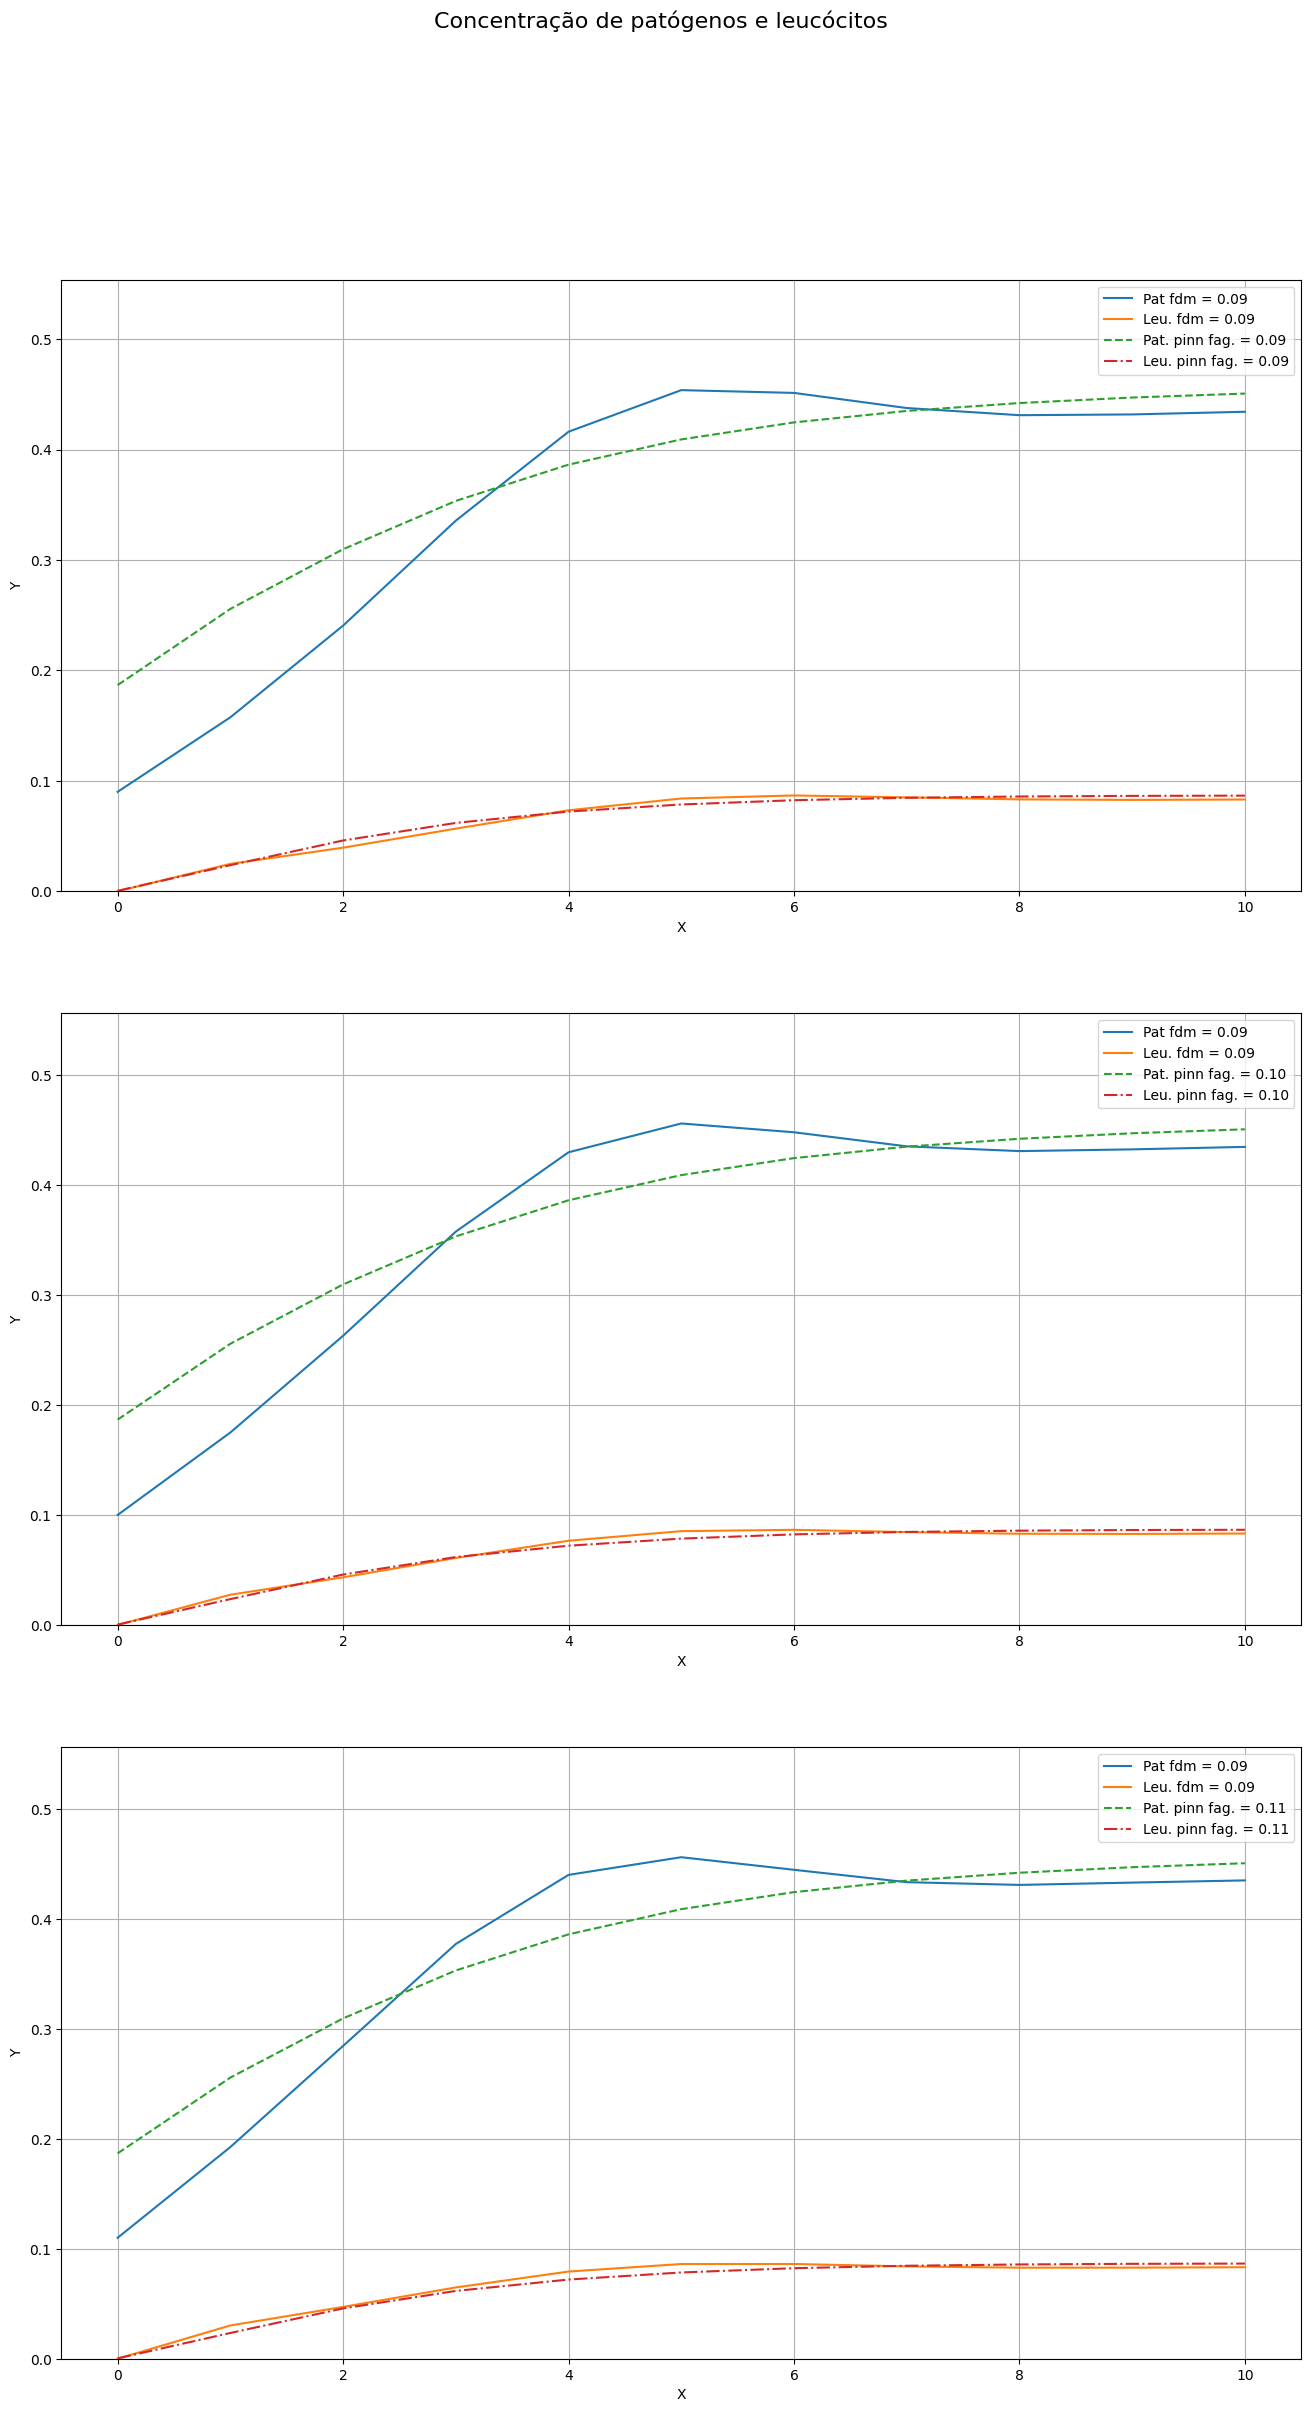

In [46]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=[16, 27])

fig.suptitle("Concentração de patógenos e leucócitos", fontsize=16)


vmin = 0

cp_real_1 = Cp_old[0, :]
cl_real_1 = Cl_old[0, :]
cp_pinn_1 = Cp_pinn_np[0, :]
cl_pinn_1 = Cl_pinn_np[0, :]
fag_1 = initial[0 * (size_t + 1)].cpu().detach().numpy()[0]

cp_real_2 = Cp_old[5, :]
cl_real_2 = Cl_old[5, :]
cp_pinn_2 = Cp_pinn_np[5, :]
cl_pinn_2 = Cl_pinn_np[5, :]
fag_2 = initial[5 * (size_t + 1)].cpu().detach().numpy()[0]

cp_real_3 = Cp_old[10, :]
cl_real_3 = Cl_old[10, :]
cp_pinn_3 = Cp_pinn_np[10, :]
cl_pinn_3 = Cl_pinn_np[10, :]
fag_3 = initial[10 * (size_t + 1)].cpu().detach().numpy()[0]

# Plotango 3D
ax = fig.add_subplot(3, 1, 1)

ax.plot(t_np, cp_real_1, label="Pat fdm = {:.2f}".format(fag_1))
ax.plot(t_np, cl_real_1, label="Leu. fdm = {:.2f}".format(fag_1))
ax.plot(t_np, cp_pinn_1, "--", label="Pat. pinn fag. = {:.2f}".format(fag_1))
ax.plot(t_np, cl_pinn_1, "-.", label="Leu. pinn fag. = {:.2f}".format(fag_1))
ax.set_xlabel("X")
ax.set_ylabel("Y")

vmax = np.max(
    [
        np.max(cp_real_1),
        np.max(cl_real_1),
        np.max(cp_pinn_1),
        np.max(cl_pinn_1),
    ]
)
ax.set_ylim(vmin, vmax + 0.1)
ax.legend()
ax.grid()

ax = fig.add_subplot(3, 1, 2)

ax.plot(t_np, cp_real_2, label="Pat fdm = {:.2f}".format(fag_1))
ax.plot(t_np, cl_real_2, label="Leu. fdm = {:.2f}".format(fag_1))
ax.plot(t_np, cp_pinn_2, "--", label="Pat. pinn fag. = {:.2f}".format(fag_2))
ax.plot(t_np, cl_pinn_2, "-.", label="Leu. pinn fag. = {:.2f}".format(fag_2))
ax.set_xlabel("X")
ax.set_ylabel("Y")
vmax = np.max(
    [
        np.max(cp_real_2),
        np.max(cl_real_2),
        np.max(cp_pinn_2),
        np.max(cl_pinn_2),
    ]
)
ax.set_ylim(vmin, vmax + 0.1)
ax.legend()
ax.grid()

ax = fig.add_subplot(3, 1, 3)

ax.plot(t_np, cp_real_3, label="Pat fdm = {:.2f}".format(fag_1))
ax.plot(t_np, cl_real_3, label="Leu. fdm = {:.2f}".format(fag_1))
ax.plot(t_np, cp_pinn_3, "--", label="Pat. pinn fag. = {:.2f}".format(fag_3))
ax.plot(t_np, cl_pinn_3, "-.", label="Leu. pinn fag. = {:.2f}".format(fag_3))
ax.set_xlabel("X")
ax.set_ylabel("Y")
vmax = np.max(
    [
        np.max(cp_real_3),
        np.max(cl_real_3),
        np.max(cp_pinn_3),
        np.max(cl_pinn_3),
    ]
)
ax.set_ylim(vmin, vmax + 0.1)
ax.legend()
ax.grid()

plt.show()